In [1]:
%cd ~/code/projects/nn-play/
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import os
from tqdm import tqdm, trange

from structured_container import DataContainer
from torch_nets import *
import my_utils
import random

/home/ira/code/projects/nn-play


In [2]:
BATCH_SIZE = 4
EP_LEN = 100

DATA_TRAIN = DataContainer('/home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/train.pt', batch_size=BATCH_SIZE, ep_len_read=EP_LEN)
DATA_TEST = DataContainer('/home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/test.pt', batch_size=BATCH_SIZE, ep_len_read=EP_LEN)
DATA_TRAIN.populate_images()
DATA_TEST.populate_images()

Loading /home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/train.pt
Loading /home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/test.pt


In [3]:
GAN_BATCH_SIZE = 16
AVERAGING_BATCH_SIZE = GAN_BATCH_SIZE

GUARANTEED_PERCEPTS = 6
UNCERTAIN_PERCEPTS = 4
P_NO_OBS = 0.99
EPOCHS = 225
UPDATES_PER_EPOCH = 1000
EXP_FOLDER = "/home/ira/code/projects/nn-play/experiments/paegan-state/"
DATA_FOLDER = "{}/data".format(EXP_FOLDER)

In [4]:
def mask_percepts(images, p, return_indices=False):
    images_masked = np.copy(images)
    if p < 1.0:
        for_removal = np.random.random(EP_LEN) < p
    else:
        for_removal = np.ones(EP_LEN) > 0

    if UNCERTAIN_PERCEPTS > 0:
        clear_percepts = GUARANTEED_PERCEPTS + np.random.randint(0, UNCERTAIN_PERCEPTS)
    else:
        clear_percepts = GUARANTEED_PERCEPTS
    for_removal[0:clear_percepts] = False
    images_masked[:, for_removal, ...] = 0

    if return_indices:
        return images_masked, for_removal
    else:
        return images_masked

In [5]:
start_at_epoch=27
train_gan=True
train_av=True
n_epochs=EPOCHS

try:
    os.makedirs(EXP_FOLDER)
except OSError:
    pass

data_train = DATA_TRAIN
data_test = DATA_TEST

if torch.cuda.is_available():
    net = VisualPAEGAN(v_size=V_SIZE, bs_size=BS_SIZE, n_size=N_SIZE, g_size=G_SIZE).cuda()
    criterion_pae = nn.MSELoss().cuda()
    criterion_gan = nn.BCELoss().cuda()
    # criterion_gan = nn.MSELoss().cuda()
    criterion_gen_averaged = nn.MSELoss().cuda()

    obs_in = Variable(torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH).cuda())
    obs_out = Variable(torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH).cuda())

    averaging_noise = Variable(torch.FloatTensor(AVERAGING_BATCH_SIZE, N_SIZE).cuda())
    noise = Variable(torch.FloatTensor(GAN_BATCH_SIZE, N_SIZE).cuda())

    fixed_noise = Variable(torch.FloatTensor(GAN_BATCH_SIZE, N_SIZE).normal_(0, 1).cuda())
    fixed_bs_noise = Variable(torch.FloatTensor(GAN_BATCH_SIZE, BS_SIZE).uniform_(-1, 1).cuda())
    label = Variable(torch.FloatTensor(GAN_BATCH_SIZE, 1).cuda())
else:
    net = VisualPAEGAN(v_size=V_SIZE, bs_size=BS_SIZE, n_size=N_SIZE, g_size=G_SIZE)
    criterion_pae = nn.MSELoss()
    criterion_gan = nn.BCELoss()
    # criterion_gan = nn.MSELoss()
    criterion_gen_averaged = nn.MSELoss()

    obs_in = Variable(torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH))
    obs_out = Variable(torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH))

    averaging_noise = Variable(torch.FloatTensor(AVERAGING_BATCH_SIZE, N_SIZE))
    noise = Variable(torch.FloatTensor(GAN_BATCH_SIZE, N_SIZE))

    fixed_noise = Variable(torch.FloatTensor(GAN_BATCH_SIZE, N_SIZE).normal_(0, 1))
    fixed_bs_noise = Variable(torch.FloatTensor(GAN_BATCH_SIZE, BS_SIZE).uniform_(-1, 1))
    label = Variable(torch.FloatTensor(GAN_BATCH_SIZE, 1))

real_label = 1
fake_label = 0

optimiser_pae = optim.Adam([{'params': net.bs_prop.parameters()},
                            {'params': net.decoder.parameters()}],
                           lr=0.0003)
optimiser_g = optim.Adam([{'params': net.bs_prop.parameters(), 'lr': 0.00005},
                          {'params': net.G.parameters(), 'lr': 0.0002}])
# optimiser_g = optim.Adam(net.G.parameters(), lr=0.0002)
optimiser_sum = optim.Adam(net.G.parameters(), lr=0.0002)
optimiser_d = optim.Adam(net.D.parameters(), lr=0.0002)

if start_at_epoch > 0:
    net.load_state_dict(torch.load("%s/paegan_epoch_%d.pth" % (EXP_FOLDER, start_at_epoch - 1)))

postfix = {}
for epoch in range(start_at_epoch, n_epochs):
    bar = trange(UPDATES_PER_EPOCH)
    postfix['epoch'] = '[%d/%d]' % (epoch, EPOCHS)
    for update in bar:
        losses = []
        
        batch = data_train.get_batch_episodes()
        masked = mask_percepts(batch, p=P_NO_OBS)

        batch = batch.transpose((1, 0, 4, 2, 3))
        masked = masked.transpose((1, 0, 4, 2, 3))

        batch = torch.FloatTensor(batch)
        masked = torch.FloatTensor(masked)

        net.zero_grad()

        obs_in.data.copy_(masked)
        obs_out.data.copy_(batch)

        # generate beliefs states
        states = net.bs_prop(obs_in)
        states = states.view(EP_LEN * BATCH_SIZE, -1)

        # generate observation expectations, compute pae gradients, update
        obs_expectation = net.decoder(states)
        obs_expectation = obs_expectation.view(obs_in.size())

        err_pae = criterion_pae(obs_expectation, obs_out)
        states = states.detach()
        losses.append(err_pae)
#         err_pae.backward(retain_graph=True)
#         optimiser_pae.step()
        postfix['pae train loss'] = err_pae.data[0]

        if train_gan is True:
            net.zero_grad()

            # # flip labels
            # if update % 2000 == 0:
            #     if real_label == 1:
            #         real_label = 0
            #         fake_label = 1
            #     else:
            #         real_label = 1
            #         fake_label = 0
            # train discriminator with real data
            label.data.fill_(real_label)
            
            
            obs_out_non_ep = obs_out.view(EP_LEN * BATCH_SIZE,
                                          obs_out.size(2), obs_out.size(3), obs_out.size(4))
            # draw real observations for D training
            draw = np.random.choice(EP_LEN * BATCH_SIZE, size=GAN_BATCH_SIZE, replace=False)
            obs_d = obs_out_non_ep[draw, ...]
            
            # draw states for D training
            draw = np.random.choice(EP_LEN * BATCH_SIZE, size=GAN_BATCH_SIZE, replace=False)
            states_d = states[draw, ...]
            
#             obs_out_non_ep = obs_out_non_ep.unfold(0, 1, (EP_LEN*BATCH_SIZE)//GAN_BATCH_SIZE).squeeze(-1)
#             states_non_ep = states.unfold(0, 1, (EP_LEN*BATCH_SIZE)//GAN_BATCH_SIZE).squeeze(-1)

            out_D_real = net.D(obs_d)
            err_D_real = criterion_gan(out_D_real, label)
            losses.append(err_D_real)
        
#             err_D_real.backward()
            # D_x = out_D_real.data.mean()

            # print('out_D_real', out_D_real.data)
            # print('err_D_real', err_D_real.data[0])

            # train discriminator with fake data
            noise.data.normal_(0, 1)
            obs_sample = net.G(noise, states_d)
            obs_sample = net.decoder(obs_sample)
            label.data.fill_(fake_label)
            out_D_fake = net.D(obs_sample.detach())
#             print(out_D_fake.size(), out_D_real.size())
            err_D_fake = criterion_gan(out_D_fake, label)
            losses.append(err_D_fake)
            
#             err_D_fake.backward()
            # D_G_z1 = out_D_fake.data.mean()

            # print('out_D_fake', out_D_fake.data)
            # print('err_D_fake', err_D_fake.data[0])

            err_D = (err_D_fake + err_D_real)/2
#             optimiser_d.step()

            for _ in range(1):
                # train generator using discriminator
                net.zero_grad()

                # draw states for G training
                draw = np.random.choice(EP_LEN * BATCH_SIZE, size=GAN_BATCH_SIZE, replace=False)
                states_g = states[draw, ...]

                noise.data.normal_(0, 1)
                obs_sample = net.G(noise, states_g.detach())
                obs_sample = net.decoder(obs_sample)

                label.data.fill_(real_label)
                out_D_fake = net.D(obs_sample)
                # print('out d fake', out_D_fake)
                err_G = criterion_gan(out_D_fake, label)
                losses.append(err_G)
                
#                 err_G.backward()
                # D_G_z2 = out_D_fake.data.mean()
#                 optimiser_g.step()
            
#             postfix['g train loss'] = err_G.data[0]
            postfix['d train loss'] = err_D.data[0]

            if update % 100 == 0:
#                 print(obs_out_non_ep.size())
                vutils.save_image(obs_d.data,
                        '%s/real_samples.png' % EXP_FOLDER,
                        normalize=True)
#                 obs_sample = net.G(fixed_noise, fixed_bs_noise)
                obs_sample = net.G(fixed_noise, states_g)
                
                obs_sample = net.decoder(obs_sample)
                vutils.save_image(obs_sample.data,
                        '%s/fake_samples_epoch_%03d.png' % (EXP_FOLDER, epoch),
                        normalize=False)
#                 obs_recon = net.decoder(fixed_bs_noise)
#                 vutils.save_image(obs_recon.data,
#                         '%s/expectation_samples_epoch_%03d.png' % (EXP_FOLDER, epoch),
#                         normalize=False)

        if train_av is True:
            for _ in range(1):
                net.zero_grad()
                # train generator using averaging
                # draw random states
                draw = np.random.choice(EP_LEN * BATCH_SIZE, size=1, replace=False)
                states_av = states[draw, ...]
    #             state = states[50:51, ...]
    #             print('state size', states_av.size())
                states_av = states_av.expand(AVERAGING_BATCH_SIZE, -1)
    #             print('state size', states_av.size())
                # get corresponding observation expectation
        
#               this helped a lot on gan (not surprising?)
#                 obs_exp = obs_out_non_ep[draw, ...]

#               this is what was intended...
                obs_exp = obs_expectation.view(EP_LEN * BATCH_SIZE,
                                          obs_out.size(2), obs_out.size(3), obs_out.size(4))
                obs_exp = obs_exp[draw, ...]
    #             print('obs size', obs_exp.size())

                # generate samples from state
                averaging_noise.data.normal_(0, 1)
                # is detaching here needed? maybe state propagation should learn from generation?
#                 n_samples = net.G(averaging_noise, states_av)
                n_samples = net.G(averaging_noise, states_av.detach())
                
                n_samples = net.decoder(n_samples)
                # print('samples size', n_samples.size())

                sample_av = n_samples.mean(dim=0)
                sample_av = sample_av.unsqueeze(0)
                
                # print('samples av size', sample_av.size())
                # print('obs_exp size', obs_exp.size())

                err_sum = criterion_gen_averaged(sample_av, obs_exp.detach())
                losses.append(err_sum)
#                 err_sum.backward()
                
                # also reward realism
#                 label.data.fill_(real_label)
#                 out_D_fake = net.D(n_samples)
#                 # print('out d fake', out_D_fake)
#                 err_G = criterion_gan(out_D_fake, label)
#                 err_G.backward(retain_graph=True)
                
#                 optimiser_sum.step()
                    
    
            postfix['g train loss'] = err_G.data[0]
            postfix['sum train loss'] = err_sum.data[0]
           
            if update % 10 == 0:
                sample_mixture = sample_av.data.cpu().numpy()
                observation_belief = obs_exp.data.cpu().numpy()
                joint = np.concatenate((observation_belief, sample_mixture), axis=-2)
                joint = np.expand_dims(joint, axis=0)
                my_utils.batch_to_sequence(joint, fpath='%s/training_sum_%03d.gif' % (EXP_FOLDER, epoch))

        if update % 500 == 0:
            recon_ims = obs_expectation.data.cpu().numpy()
            target_ims = obs_out.data.cpu().numpy()
            joint = np.concatenate((target_ims, recon_ims), axis=-2)
            my_utils.batch_to_sequence(joint, fpath='%s/training_recon_%03d.gif' % (EXP_FOLDER, epoch))

        if update % 100 == 0:
            batch = data_test.get_batch_episodes()
            masked = mask_percepts(batch, p=P_NO_OBS)
            # masked = mask_percepts(batch, p=1)

            masked = masked.transpose((1, 0, 4, 2, 3))
            masked = torch.FloatTensor(masked)
            obs_in.data.copy_(masked)

            batch = batch.transpose((1, 0, 4, 2, 3))
            batch = torch.FloatTensor(batch)
            obs_out.data.copy_(batch)

            states = net.bs_prop(obs_in)
            obs_expectation = net.decoder(states.view(EP_LEN * BATCH_SIZE, -1))
            obs_expectation = obs_expectation.view(obs_in.size())
            err_pae = criterion_pae(obs_expectation, obs_out)
            postfix['pae valid loss'] = err_pae.data[0]

        if update % 500 == 0:
            recon_ims = obs_expectation.data.cpu().numpy()
            target_ims = obs_out.data.cpu().numpy()
            joint = np.concatenate((target_ims, recon_ims), axis=-2)
            my_utils.batch_to_sequence(joint, fpath='%s/valid_recon_%03d.gif' % (EXP_FOLDER, epoch))

        sum(losses).backward()
#         optimiser_sum.step()
        optimiser_g.step()    
        
        bar.set_postfix(**postfix)

    # do checkpointing
    torch.save(net.state_dict(), '%s/paegan_epoch_%d.pth' % (EXP_FOLDER, epoch))



  0%|          | 0/1000 [00:00<?, ?it/s]/home/ira/code/envs/flexi/lib/python3.5/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
  4%|▎         | 35/1000 [00:02<00:59, 16.31it/s, d train loss=0.0398, epoch=[33/225], g train loss=4.65, pae train loss=0.0033, pae valid loss=0.00161, sum train loss=0.000411]   

KeyboardInterrupt: 

In [5]:
start_at_epoch = 20

In [6]:
%cd ~/code/projects/nn-play/
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
import torch
from IPython.display import HTML
%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')
from balls_sim import World, DEFAULT_SIM_CONFIG
from particle_filter import ParticleFilter  # see here for implementational details
from torch_nets import *
gif_counter = 0

/home/ira/code/projects/nn-play


In [7]:
pae = VisualPAEGAN()
pae.load_state_dict(torch.load('experiments/paegan-state/paegan_epoch_{}.pth'.format(start_at_epoch)))

size torch.Size([260, 1, 256])
size torch.Size([260, 1, 1, 28, 28])


/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))
/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Uninformative baseline level at 0.012005551718175411


Ground truth,Particle Filter,PF Sample,Predictive AE,PAE Sample
,,,,


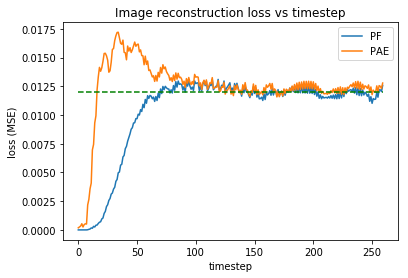

In [9]:
conf = copy.deepcopy(DEFAULT_SIM_CONFIG)
conf['radius'] = 2.0
conf['dynamics_noise'] = 0.01
conf['measurement_noise'] = 0.0003
conf['n_bodies'] = 1

w = World(**conf)
gif_counter += 1

pf = ParticleFilter(conf, n_particles=100)

pos = [body.pos for body in w.bodies]
vel = [body.vel for body in w.bodies]
pf.warm_start(pos, vel=vel)

ims = []

ims_percept = []
ims_pf_belief = []
ims_pf_sample = []

loss_mse = []
loss_sample_mse = []
loss_mae = []

RUN_LENGTH = 260

for i in range(RUN_LENGTH):
    if i < 8:
        measures = [body.pos for body in w.bodies]
        pf.update(measures)
        pf.resample()
    
    w.run()
    pf.predict()
    
    percept = w.draw()
    belief = pf.draw()[:,:,0]
    sample = pf.parts[np.random.randint(pf.n)].draw()
    
    loss_mse.append(np.mean((percept-belief)**2))
    loss_sample_mse.append(np.mean((percept-sample)**2))
    
    ims_percept.append(percept)
    ims_pf_belief.append(belief)
    ims_pf_sample.append(sample)

    
# run predictions with the network
x = np.array(ims_percept)
x = x.reshape((1, RUN_LENGTH, 28, 28, 1))
x[:,8:, ...] = 0
# x[:,:100, ...] = 0
# x[:,101:, ...] = 0

x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
# x = x.cuda()
x = Variable(x)
states = pae.bs_prop(x)

# create expected observations
obs_expectation = pae.decoder(states)
obs_expectation = obs_expectation.view(x.size())

obs_expectation = obs_expectation.data.cpu().numpy()
obs_expectation = obs_expectation.reshape((RUN_LENGTH, 28, 28))


# create observation samples (constant or varying noise accross time)
noise = Variable(torch.FloatTensor(RUN_LENGTH, N_SIZE))
# noise = Variable(torch.FloatTensor(1, N_SIZE))
noise.data.normal_(0, 1)
# noise = noise.expand(RUN_LENGTH, N_SIZE)

print('size', states.size())
#states_non_ep = states.unfold(0, 1, (EP_LEN*BATCH_SIZE)//GAN_BATCH_SIZE).squeeze(-1)

pae_samples = pae.G(noise, states.squeeze_(1))
pae_samples = pae.decoder(pae_samples)
pae_samples = pae_samples.view(x.size())
print('size', pae_samples.size())

pae_samples = pae_samples.data.cpu().numpy()
pae_samples = pae_samples.reshape((RUN_LENGTH, 28, 28))

pae_ims = []
pae_samples_ims = []
loss_pae = []
for i in range(RUN_LENGTH):
    pae_ims.append(obs_expectation[i, ...])
    pae_samples_ims.append(pae_samples[i, ...])
    loss_pae.append(np.mean((ims_percept[i]-obs_expectation[i, ...])**2))

DURATION = 0.2
imageio.mimsave("ims/{}-percept.gif".format(gif_counter), ims_percept, duration=DURATION)
imageio.mimsave("ims/{}-pf_belief.gif".format(gif_counter), ims_pf_belief, duration=DURATION)
imageio.mimsave("ims/{}-pf_sample.gif".format(gif_counter), ims_pf_sample, duration=DURATION)
imageio.mimsave("ims/{}-pae_belief.gif".format(gif_counter), pae_ims, duration=DURATION)
imageio.mimsave("ims/{}-pae_sample.gif".format(gif_counter), pae_samples_ims, duration=DURATION)

ims_ar = np.array(ims_percept)
av_pixel_intensity = np.mean(ims_ar)
baseline_level = np.mean((ims_ar-av_pixel_intensity)**2)
baseline = np.ones(len(loss_mse)) * baseline_level
print("Uninformative baseline level at {}".format(baseline_level))

plt.plot(loss_mse)
plt.plot(loss_pae)
plt.plot(baseline, 'g--')

plt.title("Image reconstruction loss vs timestep")
plt.ylabel("loss (MSE)")
plt.xlabel("timestep")
plt.legend(["PF", "PAE"])

HTML("""
<table>
  <tr>
    <th>Ground truth</th>
    <th>Particle Filter</th> 
    <th>PF Sample</th> 
    <th>Predictive AE</th>
    <th>PAE Sample</th>
  </tr>
  <tr>
    <td><img src="../ims/{0}-percept.gif" width="140"></td>
    <td><img src="../ims/{0}-pf_belief.gif" width="140"></td> 
    <td><img src="../ims/{0}-pf_sample.gif" width="140"></td>
    <td><img src="../ims/{0}-pae_belief.gif" width="140"></td>
    <td><img src="../ims/{0}-pae_sample.gif" width="140"></td>
    
  </tr>

</table>""".format(gif_counter))

In [38]:

x = Variable(torch.randn(1, IM_CHANNELS, IM_WIDTH, IM_WIDTH))
# x.fill_(0)
x.data.copy_(torch.FloatTensor(ims_percept[100]))
code = pae.bs_prop.encoder(x)

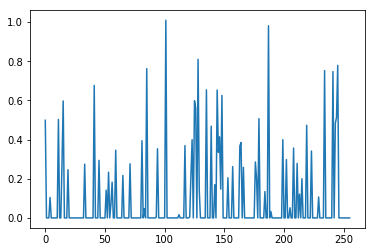

  1%|          | 9/1000 [00:20<36:44,  2.22s/it, d train loss=7.14, epoch=[35/225], g train loss=0.00112, pae train loss=0.00765, pae valid loss=0.00957, sum train loss=0.0214]

In [39]:
plt.plot(code.data.squeeze())

torch.FloatTensor